<img src="julia-computing.svg" width="200">

# Miletus: Pricing Analytics in Julia
### Simon Byrne, Ranjan Anantharaman
#### Julia Computing


## Background

Core problems: 
1. How do you represent a financial contract?
    - Huge variety of finanicial contracts 
      - e.g. forwards, options, swaps
    - Can have many variations
      - e.g. options can be American, European, Asian, Swing
2. How do you determine its value?
    - Variety of different approaches:
        - exact mathematical formulae if available (e.g. Black-Scholes)
        - lattice methods (e.g. binomial recombining trees)
        - Monte Carlo simulation



_Miletus_ is a Julia package providing:
1. a flexible contract definition language, and
2. a suite of high-performance valuation methods supporting such contracts.

Exploit many of Julia's powerful features:
- Fast and accessible user-defined types
- Generic programming and multiple dispatch
- Aggressive JIT compiler
- Composability with other libraries for features such as automatic differentiation (AD)
- Expressive language

In [1]:
using Miletus
using Base.Dates
using Miletus.TermStructure
using Miletus.DayCounts
using BusinessDays
using Gadfly, Colors

import Miletus: When, Give, Receive, Buy, Both, At, AtObs, Either, Zero
import Miletus: YieldModel, maturitydate
import Miletus.TermStructure: ConstantContinuousYieldCurve
import BusinessDays: USGovernmentBond

## Contract Specification Language

Complex Financial contracts can be deconstructed into a set of **primitive** components. 

Inspired by the work of Simon Peyton Jones and Jean-Marc Eber: "How to write a financial contract"
- Haskell implementation based on nested combinators.

Our approach is based on nested parametric types

**Zero** is the "null" primitive contract, which has no rights or obligations.

In [2]:
Zero()

Zero


**Receive** is a primitive contract which gives the owner a fixed amount of money.

In [3]:
# A contract where you receive 100 US dollars
a = Receive(100USD)

Amount
 └─100USD


**Give** reverses the obligation of the contract

In [4]:
# A contract where you owe 100 USD
Give(Receive(100USD))

Give
 └─Amount
    └─100USD


In [5]:
# Pay is shorthand for the above
Pay(100USD)

Give
 └─Amount
    └─100USD


**SingleStock** represents an arbitrary asset

In [6]:
s = SingleStock()

SingleStock


**Both** is a primitive which inherits the rights and obligations of 2 contracts.

In [7]:
# A contract to purchase SingleStock for 100 USD
Both(SingleStock(), Pay(100USD))

Both
 ├─SingleStock
 └─Give
    └─Amount
       └─100USD


In [8]:
# Buy is a shorthand form
b = Buy(SingleStock(), 100USD)

Both
 ├─SingleStock
 └─Give
    └─Amount
       └─100USD


In [9]:
# the structure of the object matches that of the contract
typeof(b)

Miletus.Both{Miletus.SingleStock,Miletus.Give{Miletus.Amount{Miletus.ConstObs{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Int64}}}}}

**When** is a primitive in which the holder aquires the nested contract when the predicate condition becomes true.

_Example_: A zero coupon bond is a contract to receive a single payment at some future date.

In [10]:
ZCB(Date("2017-12-25"), 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Amount
    └─100USD


_Example_: A forward contract is an agreement to purchase an asset for a fixed price at a future date.

In [11]:
When(At(Date("2017-12-25")), Buy(SingleStock(),80USD))

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Both
    ├─SingleStock
    └─Give
       └─Amount
          └─80USD


**Either** is a primitive in which the holder aquires either (but not both) of the nested contracts.

_Example_: A European Call option allows the holder the option (but no obligation) to aquire an asset on a future date for a price fixed now.

In [12]:
eucall = EuropeanCall(Date("2017-12-25"), SingleStock(), 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─SingleStock
    │  └─Give
    │     └─Amount
    │        └─100USD
    └─Zero


**Anytime** is a primitive that allows the holder to aquire the nested conrtact whenever the predicate is true.

_Example_: An American Put option allows the holder the option (but no obligation) to sell an asset anytime before a specific date for a price fixed now.

In [13]:
amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)

Anytime
 ├─{<=}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─Give
    │  │  └─SingleStock
    │  └─Amount
    │     └─100USD
    └─Zero


## Models

A contract captures the fixed/objective parameters
 - e.g. strike price, maturity date

A `Model` captures the varying/subjective parameters
 - starting price of asset (spot price)
 - discount rate (risk free rate of return) 
 - carry rate (e.g. dividend return or cost of storage of asset)
 - stochastic process of the asset price

### Example: Geometric Brownian Motion 

The workhorse model of quantitative finance (the basis of the Black-Scholes formula)

\begin{equation}
    dS_t = \mu \, S_t \, dt + \sigma \,S_t \,dW_t
\end{equation}

Has two parameters:
 - $\sigma$ ("volatility"): free parameter
 - $\mu$ ("drift"): determined so that the model is _risk neutral_
   - the average return is the same for all assets (does not depend risk)

In [14]:
# Parameters: 
# - Start date = today
# - Start price = 100 USD (initial price at start date)
# - Interest rate = 0.1 (risk free interest rate)
# - Carry rate = 0.05 (return from holding asset)
# - Volatility = 0.15
m = GeomBMModel(today(), 100.0USD, 0.1, 0.05, .15)

Geometric Brownian Motion Model
-------------------------------
S₀ = 100.0USD
T = 2017-06-20
Yield Constant Continuous Curve with r = 0.1, T = 2017-06-20 
Carry Constant Continuous Curve with r = 0.05, T = 2017-06-20 
σ = 0.15


The `value` function computes the present value of a contract under the assumptions of a model.

In [15]:
# value the stock under the assumptions of the model
value(m, SingleStock())

100.0USD

In [16]:
# Value contract which buys the stock at 80 USD
value(m, Buy(SingleStock(),80USD))

20.0USD

In [17]:
# Value of a forward contract
value(m, When(At(Date("2017-12-25")),Buy(SingleStock(),80USD)))

21.473765065505347USD

We can recognise when known closed-form expressions exist, e.g. the Black-Scholes formula for European options:

In [18]:
# This uses the closed form solution (mathematical formula)
value(m, eucall)

5.486733773067332USD

Not all contracts have a known exact solution:

In [19]:
value(m, amput)

LoadError: MethodError: no method matching value(::Miletus.GeomBMModel{Miletus.CoreModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64}},Float64}, ::Miletus.Anytime{Miletus.LiftObs{Base.#<=,Tuple{Miletus.DateObs,Miletus.ConstObs{Date}},Bool},Miletus.Either{Miletus.Both{Miletus.Give{Miletus.SingleStock},Miletus.Amount{Miletus.ConstObs{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Int64}}}},Miletus.Zero}})[0m
Closest candidates are:
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.MonteCarloModel}[0m, [1m[31m::StepRange{Date,S}[0m, [1m[31m::Integer[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/montecarlo.jl:125
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.MonteCarloModel}[0m, [1m[31m::Integer[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/montecarlo.jl:129
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.LeastSquaresMonteCarlo}[0m, [1m[31m::Integer[0m, [1m[31m::Integer[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/lsmc.jl:34
  ...[0m

### Lattice Models

Lattice models are based discretising the price process over a grid-like layout.

![CRR Model](crr.jpg)

In [20]:
# Cox-Ross-Rubinstein discretisation of a geometric Brownian motion
# API Similar to GeomBMModel, but you specify a start and an end date
crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15) 

Miletus.BinomialGeomRWModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Float64,Float64}

In [21]:
value(crrm, eucall) # exact was 5.4867

5.485673171708775USD

In [22]:
value(crrm, amput)

3.2900148935792166USD

### Monte Carlo Models

Monte Carlo models are based on simulating multiple independent price paths and using these to value the contract.

In [23]:
# Simulate from the geometric Brownian motion
mcm = Miletus.montecarlo(m, today():Date("2017-12-25"), 10_000) 

Monte Carlo Model
-----------------
10000 Simulations everyday from 2017-06-20 to 2017-12-25
Yield Constant Continuous Curve with r = 0.1, T = 2017-06-20 


In [24]:
theme=Theme(default_color=Colors.RGBA{Float32}(0.1, 0.1, 0.7, 0.1))
plot_paths(mcm, r) = 
plot([layer(x=mcm.dates,y=mcm.paths[i,:]./USD,Geom.line,theme) for i = r]..., 
Guide.ylabel("USD"),Guide.xlabel("t"))

plot_paths (generic function with 1 method)

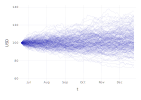

In [25]:
plot_paths(mcm,1:200)

In [26]:
value(mcm, eucall) # exact was 5.4867

5.421703975428703USD

#### Asian Options

Asian options involve average of an asset prices over some window. 

Easy using Monte Carlo, difficult with other methods.

In [27]:
# Asian fixed strike option based on average of the past month
asian = AsianFixedStrikeCall(Date("2017-12-25"), SingleStock(), Dates.Month(1), 100.00USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─MovingAveragePrice
    │  │  ├─SingleStock
    │  │  └─1 month
    │  └─Give
    │     └─Amount
    │        └─100.0USD
    └─Zero


In [28]:
value(mcm, asian)

5.097968950128164USD

# A peek under the hood


Julia types are composed to specify contracts.
 - This structure is leveraged in the computation routines.
 
Algorithms are very different, but share the core kernel function `valueat`
- similar to `value`, but takes extra state arguments
- specifies the underlying valuation logic

Basic primitives:

```julia
# Zero is worth, well, zero
@inline valueat(m::AbstractModel, c::Zero, state...) =
    0.0*numeraire(m) # numeraire is the reference currency

# "Give" negates the value
@inline valueat(m::AbstractModel, c::Give, state...) =
    -valueat(m,c.c,state...)

# "Both" is the sum of the nested values
@inline valueat(m::AbstractModel, c::Both, state...) =
    valueat(m,c.c1,state...) + valueat(m,c.c2, state...)

# "Either" is the maximum of the nested values
@inline valueat(m::AbstractModel, c::Either, state...) =
    max(valueat(m,c.c1,state...), valueat(m,c.c2,state...))
```

What makes this possible is: 
1. Multiple dispatch and generic signatures allows one function to value different kinds of primitives,
2. Aggressive compiler optimisations generates efficient code comparable to the directly written version

Other primitives require methods to be defined for each model (or class of models).

e.g. in a binomial tree, the value of the `When` primitive is defined by a backwards recursion

$$
W_{t,s} = \begin{cases}
V_{t,s} & t = T \\
\text{discount} \times \left[ P(\text{up}) \cdot W_{t+1,s+1} + P(\text{down}) \cdot W_{t+1,s-1} \right] & t < T
\end{cases} $$

where:
- $t$ is the current time
- $s$ is the level
- $V_{t,s}$ is the value of the contained contract

and the `Anytime` primitive uses a slightly different recursion to capture the option of early exercise

$$
A_{t,s} = \begin{cases}
V_{t,s} & t = T \\
\max \left\{ V_{t,s} , \text{discount} \times \left[ P(\text{up}) \cdot A_{t+1,s+1} + P(\text{down}) \cdot A_{t+1,s-1} \right] \right\} & t < T
\end{cases} $$

These need a bit more care to get right
 - We don't want to use naive recursion
 - Don't (yet) support all possible combinations (e.g. nested `When` contracts)

### Comparison with QuantLib

QuantLib is a large open source C++ quantitatve finance library
 - over 16 years old.
 - implements a huge variety of contracts and models
 - makes heavy use of templates

In [29]:
const quantlib = joinpath(Pkg.dir("Miletus"),"benchmarks/quantlib")
function quantlib_am_put_crr(S,K,r,c,σ,dt1::Date,dt2::Date, n)
    ccall((:ql_am_put_crr, quantlib), Cdouble,
          (Cdouble, Cdouble, Cdouble, Cdouble, Cdouble,
           Cint, Cint, Cint,
           Cint, Cint, Cint,
           Cint),
          S, K, r, c, σ,
          year(dt1), month(dt1), day(dt1),
          year(dt2), month(dt2), day(dt2),
          n)
end

quantlib_am_put_crr (generic function with 1 method)

In [30]:
# evaluation of american put using CRR model
quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

3.2900228353151855

In [31]:
using BenchmarkTools
@benchmark begin
    crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15) 
    amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)
    value(crrm, amput)
end

BenchmarkTools.Trial: 
  memory estimate:  14.14 KiB
  allocs estimate:  149
  --------------
  minimum time:     7.073 ms (0.00% GC)
  median time:      7.484 ms (0.00% GC)
  mean time:        8.590 ms (0.00% GC)
  maximum time:     28.103 ms (0.00% GC)
  --------------
  samples:          579
  evals/sample:     1

In [48]:
# ccall quantlib
@benchmark quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

BenchmarkTools.Trial: 
  memory estimate:  1.92 KiB
  allocs estimate:  49
  --------------
  minimum time:     24.054 ms (0.00% GC)
  median time:      24.227 ms (0.00% GC)
  mean time:        24.758 ms (0.00% GC)
  maximum time:     34.581 ms (0.00% GC)
  --------------
  samples:          202
  evals/sample:     1

<img src="quantlib.png"/>

The equivalent using Miletus is:
```julia
crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15)
amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)
value(crrm, amput)
```

### Currency Units

Miletus includes a currency unit type:

In [33]:
100.00USD + 20.00USD

120.0USD

* Captures important qualitative information
* Can catch certain errors of mismatched units
* No runtime overhead abstraction

In [34]:
100.00USD + 20.00GBP

LoadError: no promotion exists for Float64 and Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:GBP},Float64}

## Other features

### Volatility curve fitting

In [35]:
strikes = 46.50:0.50:48.50
contracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in strikes]
prices = [2.24,1.95,1.69,1.45,1.23]

core = CoreModel(Date("2017-11-01"), 47.32, 0.0, 0.0)

ivols = ivol.([core], contracts, prices)

5-element Array{Float64,1}:
 0.375322
 0.370226
 0.366849
 0.363018
 0.3587  

Can fit more complex models such as the SABR:

In [36]:
sabr = fit(SABRModel, core, contracts, prices)

Miletus.SABRModel{Float64}

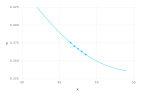

In [37]:
x_strikes = 42.00:0.50:54.00
xcontracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in x_strikes]

plot(
    layer(x=x_strikes, y=ivol.([sabr],xcontracts), Geom.line),
    layer(x=strikes, y=ivols, Geom.point))

## Greeks

Greeks are price senitivities: derivatives of the value with respect to certain parameters.
- represented by specific Greek symbols
- often used for hedging or portfolio optimisation (e.g. "delta neutral portfolio")

Delta ($\Delta$) is the derivative with respect to current asset price:

In [38]:
delta(m, eucall)

0.5996167304587916

Vega ($\nu$) Derivative of the contract value wrt volatility:

In [39]:
vega(m, eucall)

26.73063468056202USD

For lattice and Monte Carlo models, it makes wide use of _automatic differentiation_ 
 - see [www.juliadiff.org](www.juliadiff.org) or [www.wilmott.com/automatic-for-the-greeks/](www.wilmott.com/automatic-for-the-greeks/)
 - more accurate than usual finite differencing techniques. 

In [49]:
vega(m, eucall, MonteCarloModel, today():Date("2017-12-25"), 10000)

27.351342287327824USD

In [53]:
vega(m, asian, MonteCarloModel, today():Date("2017-12-25"), 10000)

25.378296831763016USD

And more:
 - Stochastic volatility models
 - Risk-neutral pricing from futures prices
 - Least squares Monte Carlo
 - Multiple exercise (swing) options

We also have lots more features planned:
 - Richer asset structure
 - Multifactor models
 - Support for exotic derivatives across currency, stock and commodities markets.

<img src="juliafin.svg" width="200">

Try it out: [www.juliacomputing.com/products/juliafin.html](www.juliacomputing.com/products/juliafin.html)

Or get in touch: 
 - simon@juliacomputing.com / @simonbyrne on GitHub
 - ranjan@juliacomputing.com / @ranjanan on GitHub